## Setup

In [5]:
import sys 
sys.path.append("../../bin/")
from metabo_funcs import *
%load_ext autoreload
%autoreload 2
sns.set_theme(font="Arial", style="white")
sns.set_style("white")
data_dir = Path("../../data/metabolomics")

AVG_INTENSITY_CUTOFF = 5000


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Cell volume data

/var/folders/_y/ykkyh0zs03x3r9jzl6tpc7rm0000gq/T/ipykernel_12572/340347939.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
/var/folders/_y/ykkyh0zs03x3r9jzl6tpc7rm0000gq/T/ipykernel_12572/340347939.py:3: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'grey'}` instead.

  ax = sns.barplot(
/var/folders/_y/ykkyh0zs03x3r9jzl6tpc7rm0000gq/T/ipykernel_12572/340347939.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(


<Axes: xlabel='condition', ylabel='cell_volume_fL'>

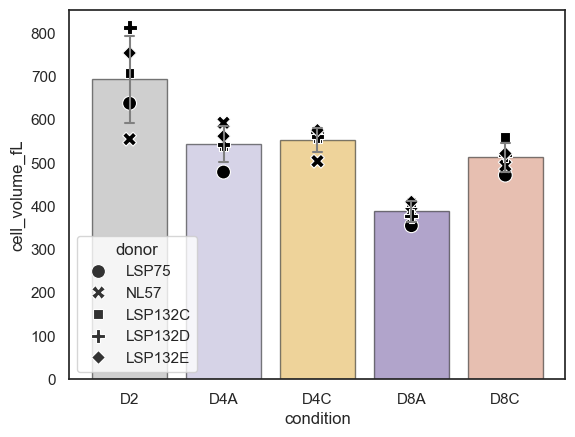

In [6]:
df = pd.read_csv(data_dir / "metabolomics/cell_volume.csv")

ax = sns.barplot(
    x="condition",
    y="cell_volume_fL",
    data=df,
    ci="sd",
    hue="condition",
    edgecolor="black",
    errcolor="grey",
    palette={
        "D2": "#A1A1A1",
        "D4A": "#ABA2D6",
        "D8A": "#603EA6",
        "D4C": "#FBB31B",
        "D8C": "#E27753",
    },
    errwidth=1.5,
    capsize=0.1,
    alpha=0.5,
)

sns.scatterplot(
    x="condition", s=100, c="black", y="cell_volume_fL", style="donor", data=df, ax=ax
)

In [7]:
mean_cell_volumes = df.drop("donor", axis = 1).groupby(["condition"]).mean().T
cell_volume_ratios = mean_cell_volumes / mean_cell_volumes["D2"].iloc[0]

display(round(cell_volume_ratios, 3))

control_cell_volume = mean_cell_volumes["D2"].iloc[0]

cell_volume_constants = mean_cell_volumes.drop("D2", axis = 1).to_dict(orient="records")[0]

condition,D2,D4A,D4C,D8A,D8C
cell_volume_fL,1.0,0.783,0.797,0.559,0.74


## Whole cell metabolomics

Read data and metadata. Rename the columns for a more readable table

In [11]:
metabo_dir = data_dir / "metabolomics"
combined_files, filtered_files, results_files, formatted_files = make_result_dirs(
    metabo_dir / "cross_replicate_analysis"
)
results_files = results_files / "cell_volume_normalized"
results_files.mkdir(exist_ok = True)
index_cols = ["Compound", "HMDB"]
metabo_df = pd.read_excel(metabo_dir / "LFSP1558_Report.xlsx").set_index(index_cols)

meta_dicts = (
    pd.read_excel(
        metabo_dir / "PMCF-LFSP-1558_Metabolomics_Sample_info_HS.xlsx", skiprows=11
    )[["Group", "Condition", "donor", "Sample #"]]
    .drop(list(range(61, 77)))
    .drop(0)
    .set_index("Sample #")
    .to_dict()
)

metabo_df.columns = metabo_df.columns.to_series().apply(
    lambda x: meta_dicts["Condition"][x.split("_S")[1]]
    + "_"
    + meta_dicts["donor"][x.split("_S")[1]]
    + "_"
    + x.split("_")[1]
)

metabo_df.to_csv(formatted_files / "metabolomics_formatted_data.csv")

Filter data on intensity cutoff. Report the percentage of missing data for each sample

In [12]:
filtered_df = filter_on_intensity_cutoff(
    metabo_df=metabo_df,
    donors=set(meta_dicts["donor"].values()),
    conditions=set(meta_dicts["Condition"].values()),
    index_cols=index_cols,
    output_path=filtered_files,
)

raw_signal_filename = combined_files / "combreplicates_raw_signal.csv"

filtered_df.reset_index().drop("HMDB", axis = 1).to_csv(raw_signal_filename, index = None)

missing_data = filtered_df.replace(0, np.nan).isnull()

print(
    "% missing data in samples\n",
    (missing_data.sum() * 100 / len(filtered_df)).sort_values(),
    "% missing data in metabolites\n",
    (missing_data.sum(axis=1) * 100 / len(filtered_df)).sort_values(),
)

% missing data in samples
 D2_NL57_S17      0.000000
D2_ZC2_S46       0.000000
D2_NL57_S16      0.574713
D2_LSP75_S01     0.574713
D2_ZC1_S31       0.574713
D2_ZC1_S32       0.574713
D2_ZC1_S33       0.574713
D2_NL57_S18      0.574713
D2_ZC2_S48       1.149425
D2_ZC2_S47       1.149425
D4C_LSP75_S07    1.724138
D2_LSP75_S03     1.724138
D4C_LSP75_S09    2.298851
D2_LSP75_S02     2.298851
D4C_ZC1_S37      2.298851
D8A_ZC1_S41      2.298851
D8C_ZC1_S43      2.298851
D4C_ZC1_S38      2.298851
D8A_NL57_S27     2.873563
D8C_ZC1_S45      2.873563
D4C_ZC1_S39      2.873563
D8A_ZC1_S40      2.873563
D8A_ZC1_S42      2.873563
D4A_ZC1_S36      2.873563
D8C_NL57_S28     2.873563
D4C_LSP75_S08    2.873563
D8A_LSP75_S10    2.873563
D4A_LSP75_S04    2.873563
D8A_NL57_S26     3.448276
D8C_LSP75_S14    3.448276
D8C_LSP75_S13    3.448276
D4A_LSP75_S06    3.448276
D8C_LSP75_S15    3.448276
D8C_NL57_S29     3.448276
D8C_NL57_S30     3.448276
D8A_LSP75_S11    3.448276
D4A_ZC1_S34      3.448276
D4C_NL57_S2

### Data imputation

Perform Quantile Regression Imputation of Left-Censored data. Call an R script to run imputeLCMD package

In [13]:
impute_LCMD_output_filename = combined_files / "metabolomics_log2_imputed_data.csv"

rscript_location = "Rscript"
subprocess.call(
    "{} --vanilla ../../bin/data_imputation.R '{}' '{}' '{}'".format(
        str(rscript_location),
        str(raw_signal_filename),
        str(impute_LCMD_output_filename),
        "Compound"
    ),
    shell=True,
)

# read results and format for analysis

impute_lcmd_results = pd.read_csv(impute_LCMD_output_filename)

np.exp2(impute_lcmd_results.set_index("Compound")).reset_index().to_csv(
    combined_files / "combreplicates_raw_signal_with_qrilc_imputation.csv"
)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.5.1     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning messages:
1: package ‘tidyverse’ was built under R version 4.1.2 
2: package ‘tibble’ was built under R version 4.1.2 
3: package ‘readr’ was built under R version 4.1.2 
Loading required package: tmvtnorm
Loading required package: mvtnorm
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: norm
This package has some major limitations
(for example, it does not work reliably when
the number

Plot the distribution of signal intensity with and without data imputation

/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


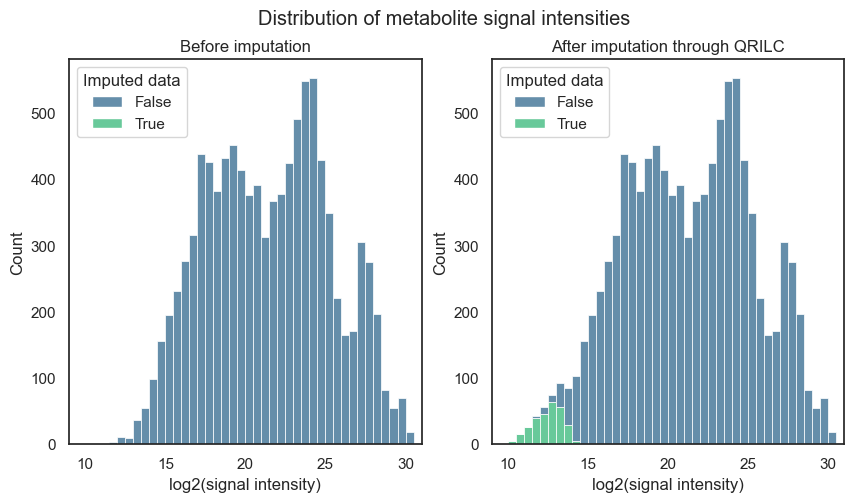

Median value of original data 3087497.600818506 
Median value of imputed data 5569.940537556999


In [14]:
imputed_data_histogram(
    index_cols,
    filtered_df,
    impute_lcmd_results,
    results_files,
    combined_files
)

In [15]:
imputed_data = pd.read_csv(combined_files / "combreplicates_raw_signal_with_qrilc_imputation.csv", index_col=0).set_index(index_cols[0])
channel_ratio_df = calc_channel_ratio(metabo_df = imputed_data, 
                                        donors = set(meta_dicts["donor"].values()), 
                                        index_cols=[index_cols[0]])
channel_ratio_df.to_csv(combined_files / "combreplicates_channel_ratio.csv")

### Cell volume normalization

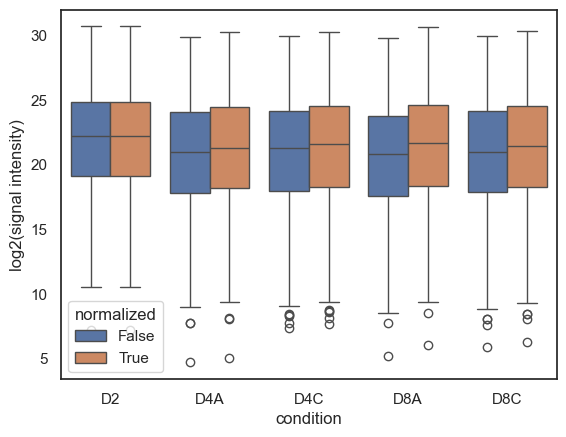

In [16]:
normalized_data = normalize_to_cell_volume(imputed_data, control_cell_volume=control_cell_volume, cell_volume_constants=cell_volume_constants)
imputed_data["normalized"] = False
normalized_data["normalized"] = True
t_data = pd.concat(
    [
        imputed_data.melt(id_vars="normalized"),
        normalized_data.melt(id_vars="normalized"),
    ]
)
t_data["condition"] = t_data["variable"].str.split("_", expand=True)[0]
t_data["log2_signal_intensity"] = np.log2(t_data["value"])
sns.boxplot(
    data=t_data, x="condition", y="log2_signal_intensity", hue="normalized"
).set_ylabel("log2(signal intensity)")
t_data.to_csv(combined_files / "transposed_normalized_data.csv")
plt.show()

channel_ratio_df = calc_channel_ratio(metabo_df = normalized_data.drop("normalized", axis = 1), 
                                        donors = set(meta_dicts["donor"].values()), 
                                        index_cols=[index_cols[0]])
channel_ratio_df.to_csv(combined_files / "combreplicates_channel_ratio.csv")

### Differential expression analysis

/Users/henrysanford/dev/T-cell-dysfunction-2025/notebooks/metabolomics/../../bin/analysis_utils.py:258: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ttest_result = stat.ttest_ind(row[cond_1], row[cond_2], nan_policy="omit")
/Users/henrysanford/dev/T-cell-dysfunction-2025/notebooks/metabolomics/../../bin/analysis_utils.py:258: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/henrysanford/dev/T-cell-dysfunction-2025/notebooks/metabolomics/../../bin/analysis_utils.py:258: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

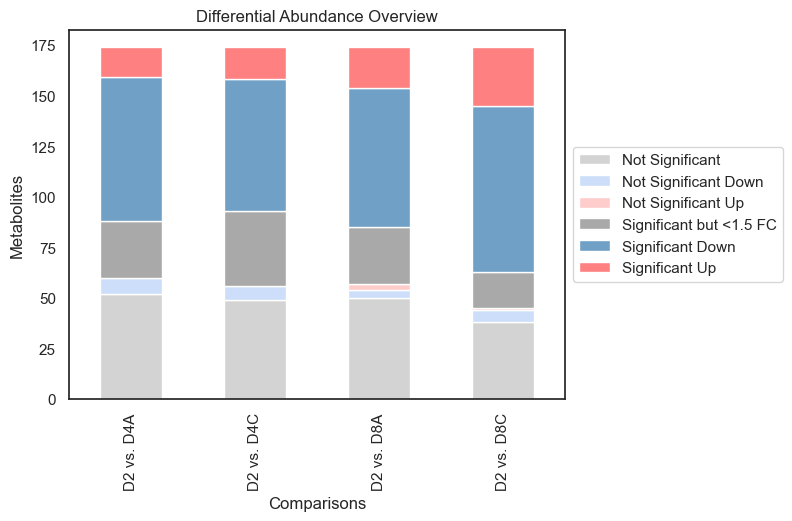

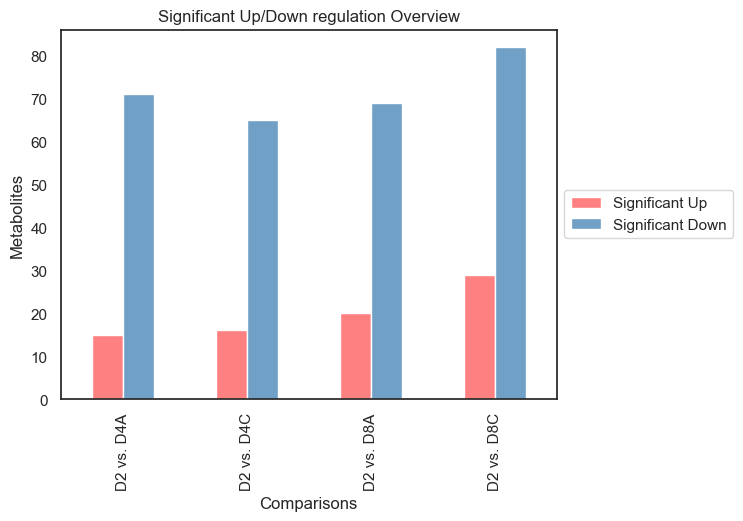

In [17]:
volcano_df, de_results = differential_expression_analysis(
    [index_cols[0]],
    results_files,
    file_name="metabolomics",
    target_name="Metabolites",
    channel_ratio_df=channel_ratio_df
)

### Principal component analysis

Run principal component analysis. Imputed data isn't helpful for this analysis, so use data before imputation

In [18]:
pca_input = calc_channel_ratio(
    metabo_df=normalize_to_cell_volume(
        filtered_df.reset_index().drop("HMDB", axis=1).set_index(index_cols[0]),
        control_cell_volume=control_cell_volume,
        cell_volume_constants=cell_volume_constants,
    ),
    donors=set(meta_dicts["donor"].values()),
    index_cols=[index_cols[0]],
)
pca_dir = results_files / "pca"
fig, loadings_df, pca_df, percent_df = get_pca_plot(
    pca_input.reset_index(), [index_cols[0]], "Metabolomics PCA", out_dir = pca_dir
)
fig

/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log2



### Final data table

In [19]:
volcano_df = volcano_df.reset_index()
de_results = [x.reset_index() for x in de_results]

# concatanate differential expression results
final_table = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        on=list(volcano_df.columns[~volcano_df.columns.str.contains("vs.")]),
        how="outer",
    ),
    de_results,
)

final_table = add_metabolite_annotation(final_table)
# merge with normalized and unnormalized channel ratio measurements
channel_ratio_df_normalized = channel_ratio_df.copy()
raw_signal = filtered_df.copy()
raw_signal.columns = [f"{x}_raw-signal-intensity" for x in raw_signal.columns]
channel_ratio_df_normalized.columns = [f"{x}_cell-volume-normalized-QRILC-imputation" for x in channel_ratio_df_normalized.columns]
final_table = raw_signal.reset_index().drop("HMDB", axis = 1).merge(right=final_table, on=index_cols[0], how="outer")
final_table = channel_ratio_df_normalized.merge(right=final_table, on=index_cols[0], how="outer")

# clean up table
final_table = final_table[
    final_table.columns[~final_table.columns.str.contains("index")]
]

column_order = list(final_table.columns[~final_table.columns.str.contains("vs.|_")])
column_order.extend(list(final_table.columns[final_table.columns.str.contains("_")]))
column_order.extend(list(final_table.columns[final_table.columns.str.contains("vs.")]))
final_table = (final_table[column_order]
               .drop("NAME", axis=1)
               .set_index(["Compound", "HMDB", "KEGG", "Alias"]))

# write to excel format
final_table.columns = [x.replace("D4A", "D4Q").replace("D8A", "D8Q") for x in final_table.columns]
final_table.to_excel("Data S3.xlsx", sheet_name="S3-1 Whole cell metabolmics", startrow=2)

# Whole cell lipidomics

In [20]:
metabo_dir = data_dir / "lipidomics"

combined_files, filtered_files, results_files, formatted_files = make_result_dirs(
    metabo_dir / "cross_replicate_analysis"
)
results_files = results_files / "cell_volume_normalized"

metabo_df = pd.read_csv(metabo_dir / "LFSP1641_Report_LSP_v2_For_HenrySanford.csv", index_col = 0)

donors = ["LSP75", "NL68"]
conditions = ["D2", "D4A", "D4C", "D8A", "D8C"]
formatted_colnames = []
for donor in donors:
    for condition in conditions:
        for i in range(1,4):
            formatted_colnames.append(f"{condition}_{donor}_{i}")

metabo_df.columns = formatted_colnames
index_cols = ["lipid"]

metabo_df.to_csv(formatted_files / "formatted_lipidomics_data.csv")

In [22]:
filtered_df = filter_on_intensity_cutoff(
    metabo_df=metabo_df,
    donors=set(donors),
    conditions=set(conditions),
    index_cols=index_cols,
    output_path=filtered_files,
)

raw_signal_filename = combined_files / "combreplicates_raw_signal.csv"

filtered_df.to_csv(raw_signal_filename)

missing_data = filtered_df.replace(0, np.nan).isnull()

print(
    "% missing data in samples\n",
    (missing_data.sum() * 100 / len(filtered_df)).sort_values(),
    "% missing data in metabolites\n",
    (missing_data.sum(axis=1) * 100 / len(filtered_df)).sort_values(),
)

% missing data in samples
 D4C_LSP75_3    0.000000
D2_NL68_1      0.232019
D4C_NL68_3     0.232019
D2_NL68_2      0.232019
D4C_LSP75_1    0.232019
D4A_LSP75_3    0.232019
D4C_LSP75_2    0.232019
D4C_NL68_1     0.464037
D2_LSP75_2     0.464037
D2_LSP75_3     0.464037
D4A_LSP75_1    0.464037
D4A_LSP75_2    0.464037
D4C_NL68_2     0.464037
D4A_NL68_3     0.696056
D4A_NL68_2     0.696056
D2_NL68_3      0.696056
D8C_LSP75_2    0.696056
D8C_NL68_2     0.696056
D8C_LSP75_3    0.928074
D8C_LSP75_1    0.928074
D4A_NL68_1     0.928074
D2_LSP75_1     0.928074
D8C_NL68_1     1.160093
D8C_NL68_3     1.160093
D8A_LSP75_1    1.624130
D8A_LSP75_2    2.088167
D8A_NL68_1     2.088167
D8A_LSP75_3    2.320186
D8A_NL68_2     2.552204
D8A_NL68_3     4.176334
dtype: float64 % missing data in metabolites
 lipid
TG 62:1      0.000000
TG 54:7      0.000000
TG 54:8      0.000000
TG 55:0      0.000000
TG 55:1      0.000000
               ...   
BMP 36:2     1.392111
PE O-32:1    1.392111
PS 32:0      2.320186
CE 

### Data imputation

In [25]:
impute_LCMD_output_filename = combined_files / "metabolomics_log2_imputed_data.csv"

rscript_location = "Rscript"
subprocess.call(
    "{} --vanilla ../../bin/data_imputation.R '{}' '{}' '{}'".format(
        str(rscript_location),
        str(raw_signal_filename),
        str(impute_LCMD_output_filename),
        index_cols[0]
    ),
    shell=True,
)

# read results and format for analysis

impute_lcmd_results = pd.read_csv(impute_LCMD_output_filename)

np.exp2(impute_lcmd_results.set_index(index_cols[0])).reset_index().to_csv(
    combined_files / "combreplicates_raw_signal_with_qrilc_imputation.csv"
)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.5.1     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning messages:
1: package ‘tidyverse’ was built under R version 4.1.2 
2: package ‘tibble’ was built under R version 4.1.2 
3: package ‘readr’ was built under R version 4.1.2 
Loading required package: tmvtnorm
Loading required package: mvtnorm
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: norm
This package has some major limitations
(for example, it does not work reliably when
the number

/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2



FileNotFoundError: [Errno 2] No such file or directory: '../../data/metabolomics/lipidomics/cross_replicate_analysis/04_results/cell_volume_normalized/data_imputation'

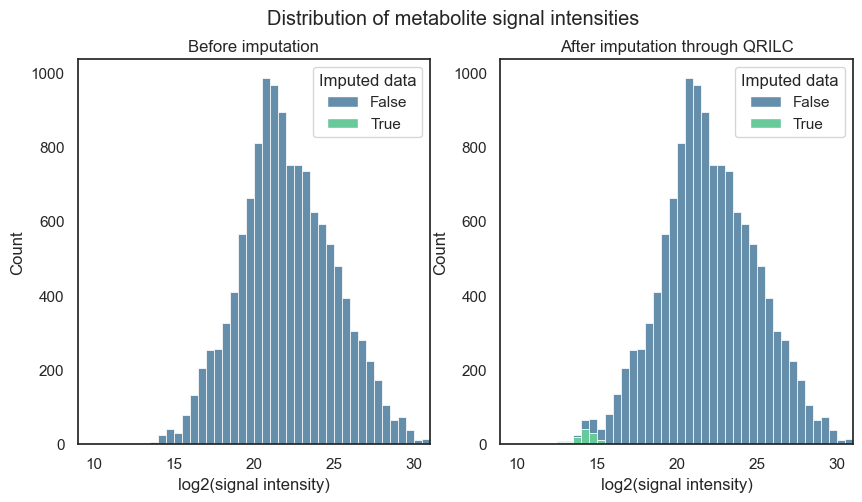

In [26]:
imputed_data_histogram(
    index_cols,
    filtered_df,
    impute_lcmd_results,
    results_files,
    combined_files
)

In [27]:
imputed_data = pd.read_csv(combined_files / "combreplicates_raw_signal_with_qrilc_imputation.csv", index_col=0).set_index(index_cols[0])
channel_ratio_df = calc_channel_ratio(metabo_df = imputed_data, 
                                        donors = set(donors), 
                                        index_cols=[index_cols[0]])
channel_ratio_df.to_csv(combined_files / "combreplicates_channel_ratio.csv")

### Cell volume normalization

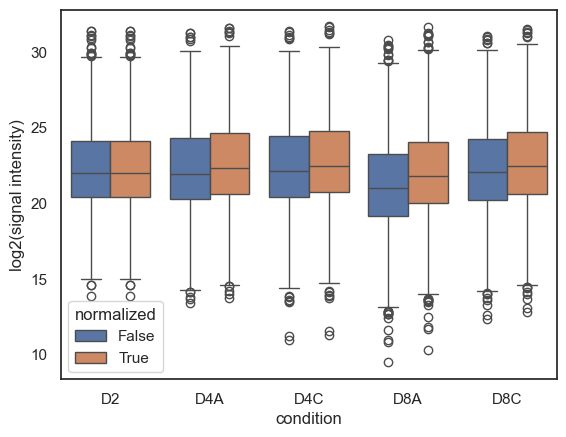

In [28]:
normalized_data = normalize_to_cell_volume(imputed_data, control_cell_volume=control_cell_volume, cell_volume_constants=cell_volume_constants)
imputed_data["normalized"] = False
normalized_data["normalized"] = True
t_data = pd.concat(
    [
        imputed_data.melt(id_vars="normalized"),
        normalized_data.melt(id_vars="normalized"),
    ]
)
t_data["condition"] = t_data["variable"].str.split("_", expand=True)[0]
t_data["log2_signal_intensity"] = np.log2(t_data["value"])
sns.boxplot(
    data=t_data, x="condition", y="log2_signal_intensity", hue="normalized"
).set_ylabel("log2(signal intensity)")
t_data.to_csv(combined_files / "transposed_normalized_data.csv")
plt.show()

channel_ratio_df = calc_channel_ratio(metabo_df = normalized_data.drop("normalized", axis = 1), 
                                        donors = set(meta_dicts["donor"].values()), 
                                        index_cols=["lipid"])
channel_ratio_df.to_csv(combined_files / "combreplicates_channel_ratio.csv")

### Differential expression analysis

In [29]:
volcano_df, de_results = differential_expression_analysis(
    ["lipid"],
    results_files,
    file_name="lipidomics",
    target_name="Lipids",
    channel_ratio_df=channel_ratio_df
)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/metabolomics/lipidomics/cross_replicate_analysis/04_results/cell_volume_normalized/volcano_plots'

### Principal component analysis

In [ ]:
pca_input = calc_channel_ratio(
    metabo_df=
    normalize_to_cell_volume(filtered_df, control_cell_volume=control_cell_volume, cell_volume_constants=cell_volume_constants),
    donors=set(donors),
    index_cols=index_cols,
)
pca_dir = results_files / "pca"
fig, loadings_df, pca_df, percent_df = get_pca_plot(
    pca_input.reset_index(), index_cols, "Lipidomics PCA", pca_dir
)
fig

/Users/henrysanford/miniconda/envs/exhaustion/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log2



In [ ]:
volcano_df = volcano_df.reset_index()
de_results = [x.reset_index() for x in de_results]

# concatanate differential expression results
final_table = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        on=list(volcano_df.columns[~volcano_df.columns.str.contains("vs.")]),
        how="outer",
    ),
    de_results,
)
annotation_table = pd.read_csv(metabo_dir / "lipid classes.csv")
final_table = annotation_table.merge(right=final_table, on=index_cols[0], how="inner")

channel_ratio_df_normalized = channel_ratio_df.copy()
raw_signal = filtered_df.copy()
raw_signal.columns = [f"{x}_raw-signal-intensity" for x in raw_signal.columns]
channel_ratio_df_normalized.columns = [f"{x}_cell-volume-normalized-QRILC-imputation" for x in channel_ratio_df_normalized.columns]
final_table = raw_signal.reset_index().merge(right=final_table, on=index_cols[0], how="outer")
final_table = channel_ratio_df_normalized.merge(right=final_table, on=index_cols[0], how="outer")

# clean up table
final_table = final_table[
    final_table.columns[~final_table.columns.str.contains("index")]
]

column_order = list(final_table.columns[~final_table.columns.str.contains("vs.|_")])
column_order.extend(list(final_table.columns[final_table.columns.str.contains("_")]))
column_order.extend(list(final_table.columns[final_table.columns.str.contains("vs.")]))
final_table = (final_table[column_order]
               .set_index([index_cols[0], "class", "broad class"]))

# write to excel format
final_table.columns = [x.replace("D4A", "D4Q").replace("D8A", "D8Q") for x in final_table.columns]
final_table.to_excel("Data S3-3.xlsx", sheet_name="S3-3 Whole cell lipidomics", startrow=2)

# Isotope tracing 

/var/folders/_y/ykkyh0zs03x3r9jzl6tpc7rm0000gq/T/ipykernel_12572/3545670199.py:15: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



0       glutamine m+2
1       glutamine m+2
2       glutamine m+2
3       glutamine m+2
4       glutamine m+2
            ...      
3955      alanine m+6
3956      alanine m+6
3957      alanine m+6
3958      alanine m+6
3959      alanine m+6
Name: molecule_variable, Length: 3960, dtype: object


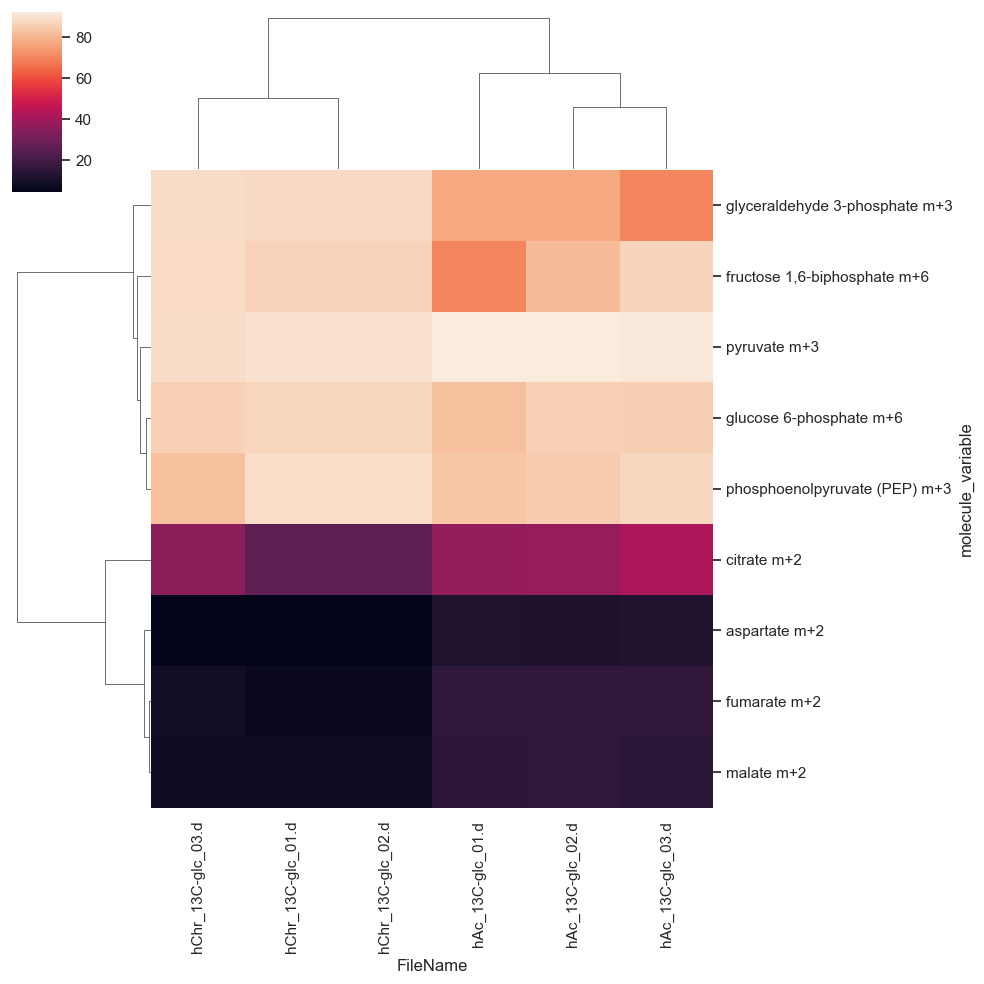

In [32]:
fn = data_dir / 'isotope_tracing/Human_Tcells_13C_data_04162021_HS_formatting.xlsx'

extra_rows = ['Glycolysis',
 'Isotopic Tracers ',
 'Methionine cycle, transsulfuration pathway and glutathione production',
 'Other compounds',
 'TCA cycle',]
keep_cols = ["m+2_NaturalIsotopeCorrectedAbundancePercentages",
             "m+3_NaturalIsotopeCorrectedAbundancePercentages",
             "m+4_NaturalIsotopeCorrectedAbundancePercentages",
             "m+5_NaturalIsotopeCorrectedAbundancePercentages",
             "m+6_NaturalIsotopeCorrectedAbundancePercentages"]

id_columns = ["BiochemicalName", "Condition", "FileName"]
df = pd.read_excel(fn, skiprows = 1).set_index(id_columns).drop(extra_rows).filter(keep_cols).reset_index().melt(id_vars=id_columns, value_name="NaturalIsotopeCorrectedAbundancePercentage")

df["isotope"] = df["Condition"].str.split("_").str[-1]
df["variable"] = df["variable"].str.split("_").str[0]
df["molecule_variable"] = df["BiochemicalName"] + " " + df["variable"]
print(df["molecule_variable"])
glc_df = df[df["isotope"] == "13C-glc"]
chosen_molecules = ["glucose 6-phosphate m+6", 
                    "fructose 1,6-biphosphate m+6",
                    "glyceraldehyde 3-phosphate m+3",
                    "phosphoenolpyruvate (PEP) m+3",
                    "pyruvate m+3",
                    "citrate m+2",
                    "fumarate m+2",
                    "malate m+2",
                    "aspartate m+2"]

pivot_df = (glc_df[glc_df["molecule_variable"]
               .isin(chosen_molecules)]
               .filter(["molecule_variable", "NaturalIsotopeCorrectedAbundancePercentage", "FileName"])
               .pivot(index = "molecule_variable", columns="FileName", values="NaturalIsotopeCorrectedAbundancePercentage"))
pivot_df.to_csv(data_dir / "isotope_tracing/13C-glc_cleaned_isotope_trace_data.csv")
sns.clustermap(pivot_df)

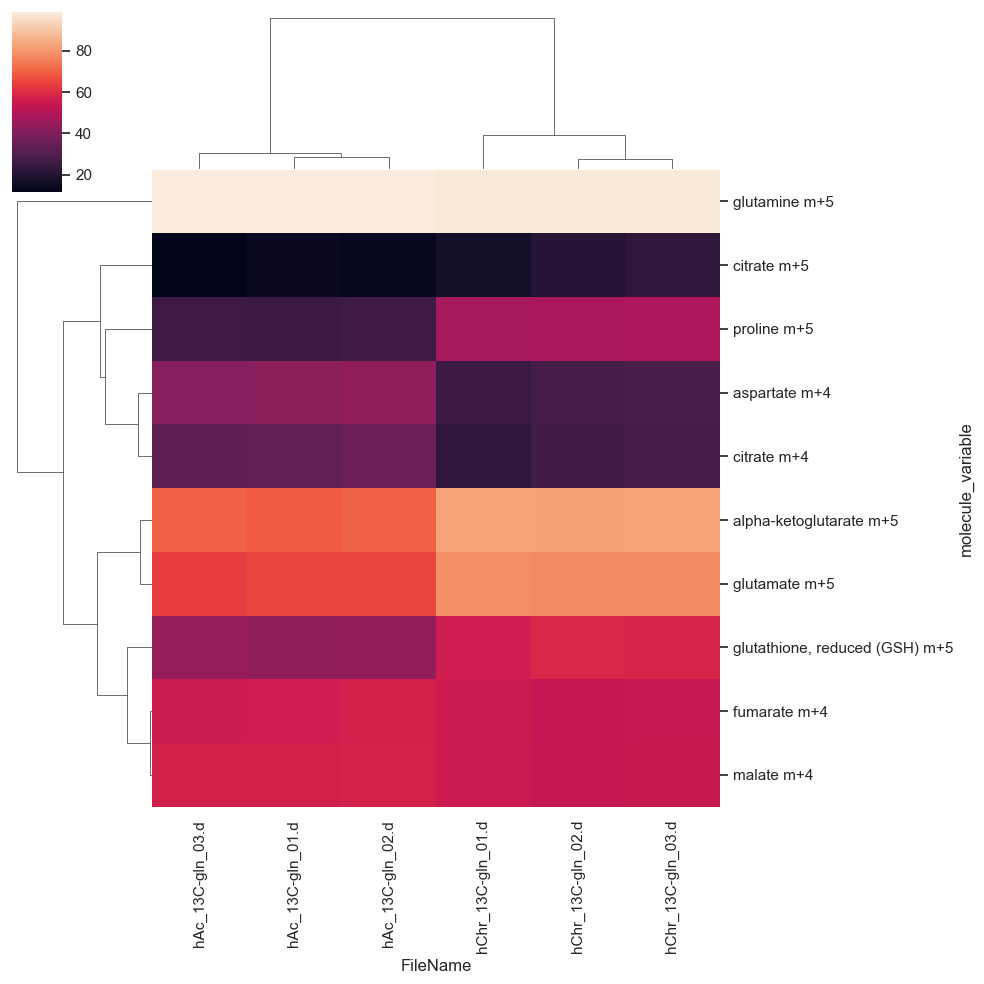

In [33]:
gln_df = df[df["isotope"] == "13C-gln"]
#  Gln - Glu - aKG - fumarate - malate - aspartate - citrate, and then a gap and then proline, and another gap and GSH
chosen_molecules = ["glutamine m+5", 
                    "glutamate m+5",
                    "alpha-ketoglutarate m+5",
                    "fumarate m+4",
                    "malate m+4",
                    "aspartate m+4",
                    "citrate m+4",
                    "proline m+5",
                    "glutathione, reduced (GSH) m+5",
                    "citrate m+5"]

pivot_df = (gln_df[gln_df["molecule_variable"]
               .isin(chosen_molecules)]
               .filter(["molecule_variable", "NaturalIsotopeCorrectedAbundancePercentage", "FileName"])
               .pivot(index = "molecule_variable", columns="FileName", values="NaturalIsotopeCorrectedAbundancePercentage"))
pivot_df.loc[chosen_molecules].to_csv(data_dir / "isotope_tracing/13C-gln_cleaned_isotope_trace_data.csv")

sns.clustermap(pivot_df)